# StrainGR gap prediction benchmarks

This notebook tests how well we can predict large deletions in the genome,
at coverages 0.1x, 0.5x, 1x and 10x.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy
import scipy
import pandas
import matplotlib.pyplot as plt
import seaborn

seaborn.set()

In [3]:
BASE_PATH = Path("benchmarks/straingr")
GENE_DEL_PATH = BASE_PATH / "straingr/gene_del"

MIN_GAP_SIZE = 5000

In [4]:
def gff_to_boolean_array(f, array, contig=None, minsize=None):
    """
    Read a GFF file and each range defined in the file will be set to True
    in `array`.

    :param f: file object to read
    :param array: NumPy array to change
    :param contig: Only include ranges specified for this contig
    :param minsize: Minimum size of a feature in the bedfile, otherwise it
                    will be ignored.
    """

    for line in f:
        fcontig, _, _, start, end, *_ = line.split()

        start = int(start)
        end = int(end)
        size = end - start

        if minsize is not None and size < minsize:
            continue

        if contig is not None and contig != fcontig:
            continue

        array[start:end] = True


def bed_to_boolean_array(f, array, contig=None, minsize=None):
    """
    Read a BED file and each range defined in the file will be set to True
    in `array`.

    :param f: file object to read
    :param array: NumPy array to change
    :param contig: Only include ranges specified for this contig
    :param minsize: Minimum size of a feature in the bedfile, otherwise it
                    will be ignored.
    """

    for line in f:
        fcontig, start, end, *_ = line.split()

        start = int(start)
        end = int(end)
        size = end - start

        if minsize is not None and size < minsize:
            continue

        if contig is not None and contig != fcontig:
            continue

        array[start:end] = True

In [5]:
gaps_data = []

for gaps_file in GENE_DEL_PATH.glob("**/straingr.gaps.bed"):
    straingr_tsv = gaps_file.with_name("straingr.tsv")
    lowmq_bed = gaps_file.with_name("straingr.lowmq.bed")
    straingr_df = pandas.read_csv(straingr_tsv, sep='\t', index_col='name')
    straingr_df = straingr_df.loc[straingr_df['ref'] != 'TOTAL']

    rel_path = gaps_file.relative_to(GENE_DEL_PATH.parent)
    sample_name = "/".join(rel_path.parts[:-2])
    coverage = float(rel_path.parts[-2][:-1])

    truth_bed = next((BASE_PATH / f"mutated_refs/{sample_name}/").glob(
        "*.genes_deleted.bed"))

    truth_gaps = {}
    predicted_gaps = {}
    lowmq = {}
    for contig in straingr_df.index:
        with truth_bed.open() as f:
            arr = numpy.zeros((straingr_df.loc[contig, 'length'],), dtype=bool)
            bed_to_boolean_array(f, arr, contig, MIN_GAP_SIZE)

            truth_gaps[contig] = arr

        with gaps_file.open() as f:
            arr = numpy.zeros((straingr_df.loc[contig, 'length'],), dtype=bool)
            bed_to_boolean_array(f, arr, contig, MIN_GAP_SIZE)

            predicted_gaps[contig] = arr
            
        with lowmq_bed.open() as f:
            arr = numpy.zeros((straingr_df.loc[contig, 'length'],), dtype=bool)
            bed_to_boolean_array(f, arr, contig)
            
            lowmq[contig] = arr
            

    contig_data = []
    for contig in straingr_df.index:
        if truth_gaps[contig].sum() == 0:
            continue
            
        jaccard = ((predicted_gaps[contig] & truth_gaps[contig]).sum() /
                   (predicted_gaps[contig] | truth_gaps[contig]).sum())
        
        # Compute jaccard with multimappable regions ignored
        truth_non_lowmq = truth_gaps[contig][~lowmq[contig]]
        predicted_non_lowmq = predicted_gaps[contig][~lowmq[contig]]
        
        jaccard_non_lowmq = ((predicted_non_lowmq & truth_non_lowmq).sum() /
                             (predicted_non_lowmq | truth_non_lowmq).sum())
        
        frac_incorrect_gap = (predicted_gaps[contig] & ~truth_gaps[contig]).sum() / truth_gaps[contig].sum()
        frac_missing_gap = (~predicted_gaps[contig] & truth_gaps[contig]).sum() / truth_gaps[contig].sum()
        frac_missing_gap_lowmq = (~predicted_gaps[contig] & truth_gaps[contig] & lowmq[contig]).sum() / truth_gaps[contig].sum()
        

        contig_data.append({
            'name': contig,
            'sample_name': sample_name,
            'orig_cov': coverage,
            'jaccard': jaccard,
            'with_lowmq': True,
            'frac_incorrect_gap': frac_incorrect_gap,
            'frac_missing_gap': frac_missing_gap,
            'frac_missing_gap_lowmq': frac_missing_gap_lowmq
        })
        contig_data.append({
            'name': contig,
            'sample_name': sample_name,
            'orig_cov': coverage,
            'jaccard': jaccard_non_lowmq,
            'with_lowmq': False,
            'frac_incorrect_gap': frac_incorrect_gap,
            'frac_missing_gap': frac_missing_gap,
            'frac_missing_gap_lowmq': frac_missing_gap_lowmq
        })

    gap_data_df = pandas.DataFrame(contig_data).set_index('name')
    gap_data_df = gap_data_df.join(straingr_df, how='inner')

    gaps_data.append(gap_data_df)

gaps_df = pandas.concat(gaps_data).reset_index().set_index([
    'sample_name', 'orig_cov', 'name']).sort_index()

gaps_df = gaps_df[gaps_df['length'] > 3e6]
gaps_df

frac_incorrect_gap  frac_missing_gap  \
sample_name    orig_cov name                                                  
gene_del/ref1  0.1      NC_017634.1              0.015029          0.482934   
                        NC_017634.1              0.015029          0.482934   
               0.5      NC_017634.1              0.009354          0.096396   
                        NC_017634.1              0.009354          0.096396   
               1.0      NC_017634.1              0.007078          0.016250   
                        NC_017634.1              0.007078          0.016250   
               10.0     NC_017634.1              0.000355          0.006848   
                        NC_017634.1              0.000355          0.006848   
gene_del/ref10 0.1      NZ_CP015240.1            0.000000          1.000000   
                        NZ_CP015240.1            0.000000          1.000000   
               0.5      NZ_CP015240.1            0.011252          0.174154   
                        NZ_CP015240.1            0.011252          0.174154   
               1.0      NZ_CP015240.1            0.005912          0.030807   
                        NZ_CP015240.1            0.005912          0.030807   
               10.0     NZ_CP015240.1            0.000347          0.081179   
                        NZ_CP015240.1            0.000347          0.081179   
gene_del/ref11 0.1      NZ_CP031919.1            0.000000          0.876830   
                        NZ_CP031919.1            0.000000          0.876830   
               0.5      NZ_CP031919.1            0.005469          0.199679   
                        NZ_CP031919.1            0.005469          0.199679   
               1.0      NZ_CP031919.1            0.007474          0.053816   
                        NZ_CP031919.1            0.007474          0.053816   
               10.0     NZ_CP031919.1            0.000271          0.060149   
                        NZ_CP031919.1            0.000271          0.060149   
gene_del/ref12 0.1      NZ_CP027027.1            0.000000          0.820993   
                        NZ_CP027027.1            0.000000          0.820993   
               0.5      NZ_CP027027.1            0.004209          0.470905   
                        NZ_CP027027.1            0.004209          0.470905   
               1.0      NZ_CP027027.1            0.001241          0.244415   
                        NZ_CP027027.1            0.001241          0.244415   
...                                                   ...               ...   
gene_del/ref6  0.5      NC_017638.1              0.005407          0.065310   
                        NC_017638.1              0.005407          0.065310   
               1.0      NC_017638.1              0.005823          0.095197   
                        NC_017638.1              0.005823          0.095197   
               10.0     NC_017638.1              0.000151          0.036936   
                        NC_017638.1              0.000151          0.036936   
gene_del/ref7  0.1      NZ_CP010237.1            0.034407          0.758373   
                        NZ_CP010237.1            0.034407          0.758373   
               0.5      NZ_CP010237.1            0.009577          0.081684   
                        NZ_CP010237.1            0.009577          0.081684   
               1.0      NZ_CP010237.1            0.005518          0.049137   
                        NZ_CP010237.1            0.005518          0.049137   
               10.0     NZ_CP010237.1            0.000698          0.023733   
                        NZ_CP010237.1            0.000698          0.023733   
gene_del/ref8  0.1      NZ_CP010145.1            0.011959          0.602765   
                        NZ_CP010145.1            0.011959          0.602765   
               0.5      NZ_CP010145.1            0.008057          0.093388   
                        NZ_CP010145.1            0.008057          0.093388   
          

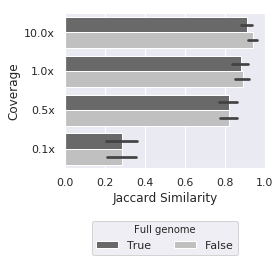

In [16]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(4, 4))

cov_order = [10.0, 1.0, 0.5, 0.1]
cov_labels = [f"{cov}x" for cov in cov_order]

#seaborn.barplot(data=gaps_df.reset_index(), x="orig_cov", y="jaccard_non_lowmq", color="silver", ax=ax)
seaborn.barplot(data=gaps_df.reset_index(), x="jaccard", y="orig_cov", orient="h", order=cov_order,
                hue="with_lowmq", hue_order=[True, False], palette=["dimgrey", "silver"], ax=ax)

ax.set_xlabel("Jaccard Similarity")
ax.set_ylabel("Coverage")
ax.set_yticklabels(cov_labels)
ax.set_xlim(0, 1.0)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ["True", "False"], title="Full genome", loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)

fig.tight_layout()
fig.savefig('paper_fig/gene_deletion_jaccard.svg')

plt.show()

In [37]:
display(gaps_df.groupby(['orig_cov', 'with_lowmq']).mean()['jaccard'])

orig_cov  with_lowmq
0.1       False         0.285010
          True          0.284662
0.5       False         0.822265
          True          0.818330
1.0       False         0.888885
          True          0.879058
10.0      False         0.941634
          True          0.908674
Name: jaccard, dtype: float64

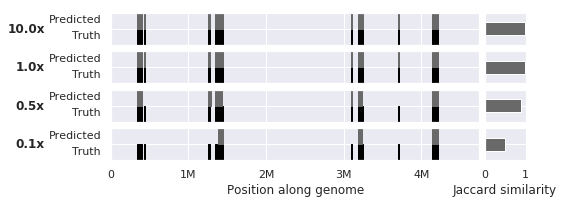

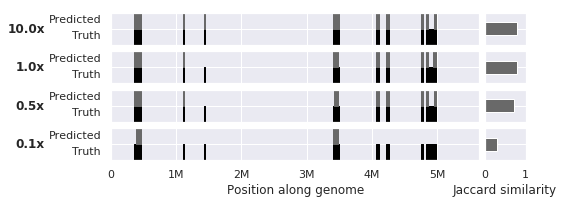

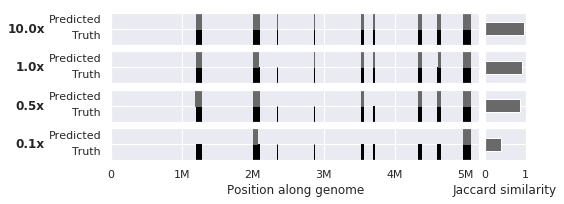

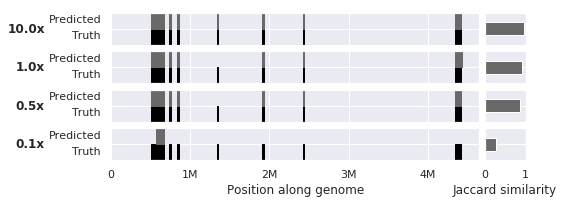

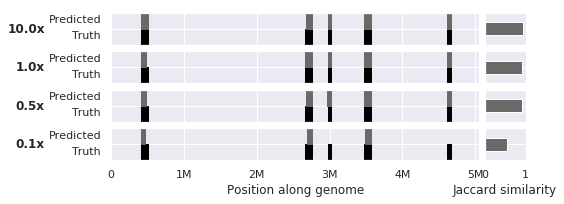

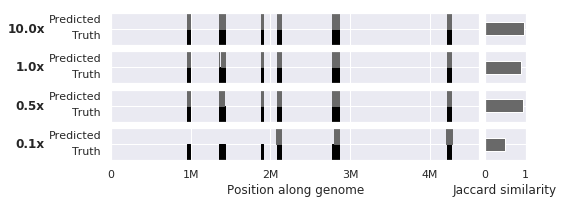

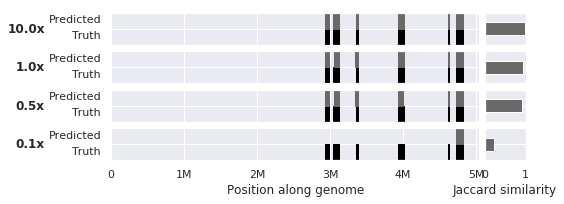

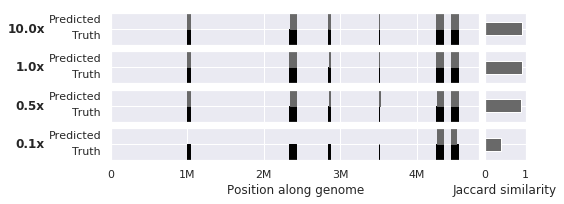

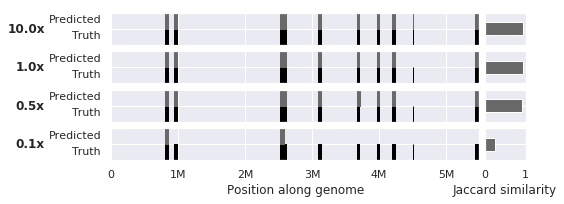

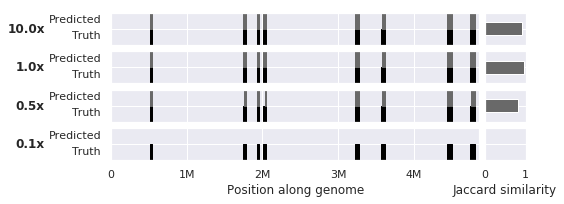

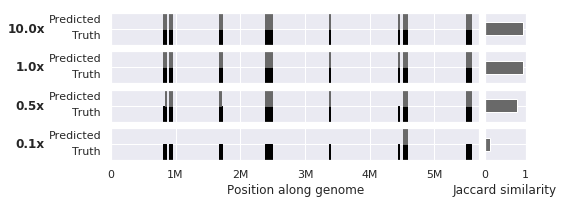

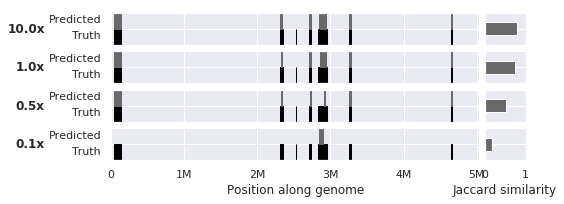

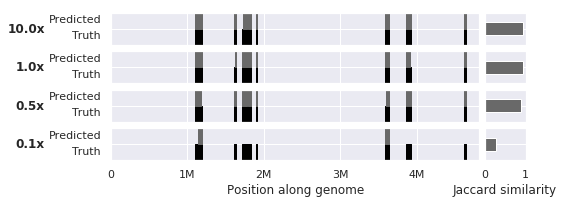

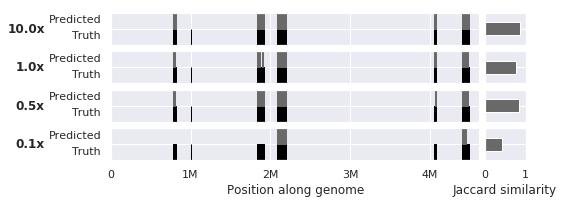

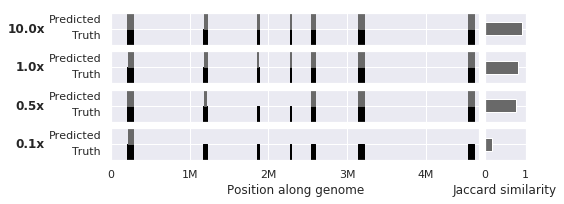

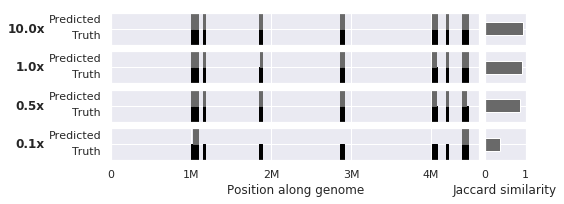

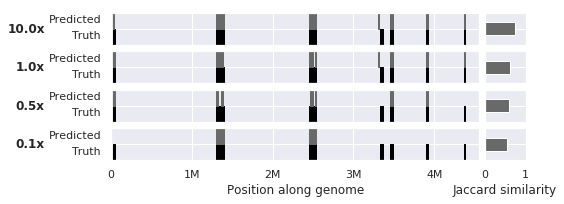

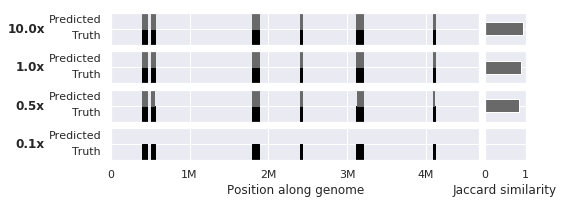

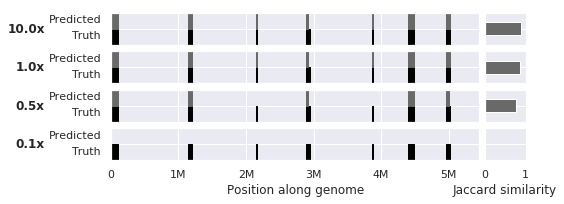

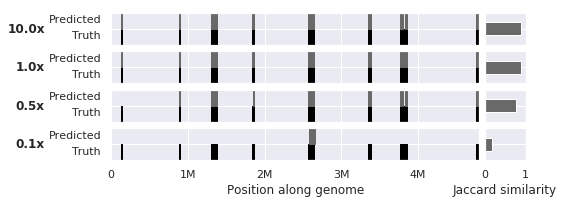

In [21]:
from math import floor, log
from IPython.display import HTML
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
from matplotlib.transforms import Affine2D

seaborn.set_context("paper")
palette = seaborn.color_palette()

gaps_df_full = gaps_df[gaps_df['with_lowmq']].copy()

def human_format(number, pos):
    if not number:
        return "0"
    
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    try:
        magnitude = int(floor(log(number, k)))
    except ValueError:
        print("Number", number)
        raise
    
    return '%g%s' % (number / k**magnitude, units[magnitude])


def plot_bed(f, y, contig=None, minsize=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    for line in f:
        fcontig, start, end, *_ = line.split()

        start = int(start)
        end = int(end)
        size = end - start

        if minsize is not None and size < minsize:
            continue

        if contig is not None and contig != fcontig:
            continue
            
        ax.fill_between([start, end], y, **kwargs)

seaborn.set() 

for refnum in range(1, 21):
    fig, axes = plt.subplots(4, 2, sharex='col', figsize=(8, 3), gridspec_kw={"width_ratios": [9, 1]})
    
    display(HTML(f"<h3>Ref: {refnum}</h3>"))
    for row, cov in enumerate(cov_order):
        gaps_file = GENE_DEL_PATH / f"ref{refnum}/{cov:g}x/straingr.gaps.bed"
        straingr_tsv = gaps_file.with_name("straingr.tsv")
        lowmq_bed = gaps_file.with_name("straingr.lowmq.bed")
        straingr_df = pandas.read_csv(straingr_tsv, sep='\t', index_col=['name'])
        straingr_df = straingr_df.loc[straingr_df['ref'] != 'TOTAL']

        rel_path = gaps_file.relative_to(GENE_DEL_PATH.parent)
        sample_name = "/".join(rel_path.parts[:-2])
        coverage = float(rel_path.parts[-2][:-1])

        truth_bed = next((BASE_PATH / f"mutated_refs/{sample_name}/").glob(
            "*.genes_deleted.bed"))

        truth_gaps = {}
        predicted_gaps = {}
        lowmq = {}

        length = 0
        chromosome = None
        for contig in straingr_df.index:
            if straingr_df.loc[contig, 'length'] < 4e6:
                continue

            with truth_bed.open() as f:
                plot_bed(f, -1, contig, MIN_GAP_SIZE, ax=axes[row, 0], color="black")

            with gaps_file.open() as f:
                plot_bed(f, 1, contig, MIN_GAP_SIZE, ax=axes[row, 0], color="dimgrey")

            chromosome = contig
            length = straingr_df.loc[contig, 'length']


        axes[row, 0].set_xlim(0, length)
        axes[row, 0].xaxis.set_major_formatter(FuncFormatter(human_format))
        axes[row, 0].set_yticklabels(["Truth", "Predicted"])
        for t in axes[row, 0].get_yticklabels():
            trans = Affine2D().translate(0, 10)
            t.set_transform(t.get_transform() + trans)
            
        axes[row, 0].set_ylabel(f"{cov}x", rotation=0, verticalalignment='center', fontweight='bold', ha='right')
        axes[row, 0].set_ylim(-1, 1)

        axes[row, 1].barh([0], [gaps_df_full.loc[(f'gene_del/ref{refnum}', cov, chromosome), 'jaccard']], color="dimgrey")
        axes[row, 1].set_xlim(0, 1.0)
        axes[row, 1].set_ylim(-1, 1)
        axes[row, 1].set_yticklabels([])

    axes[-1, 0].set_xlabel("Position along genome")
    axes[-1, 1].set_xlabel("Jaccard similarity")

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.025)
    fig.savefig(f'paper_fig/gene_deletions.ref{refnum}.svg', bbox_inches='tight')
    plt.show()